In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt



2025-07-12 16:26:31.877437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752337592.063573      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752337592.118943      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = '/kaggle/input/potholes-classification-2/train'
test_dir = '/kaggle/input/potholes-classification-2/test'
valid_dir = '/kaggle/input/potholes-classification-2/valid'


In [4]:
# Data Augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True)  # Random horizontal flip

# Only rescale the test and validation data
test_valid_datagen = ImageDataGenerator(rescale=1./255)

# Load the images from the directory and apply the transformations
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to (150, 150)
    batch_size=32,
    class_mode='binary'  # For binary classification (cats and dogs)
)

valid_generator = test_valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_valid_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 14213 images belonging to 2 classes.
Found 2427 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Load VGG16 without the fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification (pothole vs no pothole)

# Define the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


I0000 00:00:1752337690.698717      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,  # You can adjust this based on your requirements
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1752337728.410907     117 service.cc:148] XLA service 0x7e5e1c40d5d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752337728.411847     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752337728.812672     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/444 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - accuracy: 0.4531 - loss: 1.6227   

I0000 00:00:1752337737.210166     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


444/444 ━━━━━━━━━━━━━━━━━━━━ 241s 519ms/step - accuracy: 0.8255 - loss: 0.4587 - val_accuracy: 0.9325 - val_loss: 0.1810
Epoch 2/20
  1/444 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.9375 - loss: 0.1804

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


444/444 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9375 - loss: 0.1804 - val_accuracy: 0.9333 - val_loss: 0.1837
Epoch 3/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 185s 418ms/step - accuracy: 0.8864 - loss: 0.2833 - val_accuracy: 0.9371 - val_loss: 0.1632
Epoch 4/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9375 - loss: 0.2097 - val_accuracy: 0.9342 - val_loss: 0.1671
Epoch 5/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 184s 413ms/step - accuracy: 0.8920 - loss: 0.2709 - val_accuracy: 0.9433 - val_loss: 0.1558
Epoch 6/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9688 - loss: 0.1846 - val_accuracy: 0.9425 - val_loss: 0.1523
Epoch 7/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 187s 421ms/step - accuracy: 0.9076 - loss: 0.2299 - val_accuracy: 0.9337 - val_loss: 0.1708
Epoch 8/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9375 - loss: 0.1524 - val_accuracy: 0.9358 - val_loss: 0.1639
Epoch 9/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 186s 419ms/step - accuracy: 0.9079 - loss: 0.2271 - val_a

In [7]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.9403 - loss: 0.1783
Test Loss: 0.15452447533607483
Test Accuracy: 0.9442567825317383


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


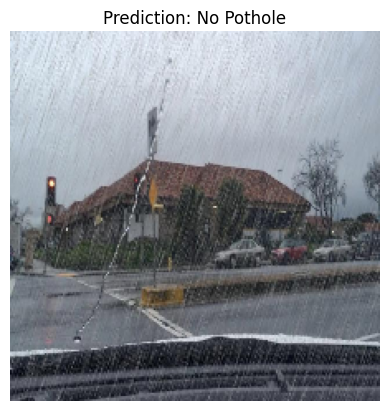

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Path to the image you want to predict
img_path = '/kaggle/input/potholes-classification-2/test/Not Pothole/05ca0197-6c0b4628_jpg.rf.bdf262f0a27a523e93e3a9f2a78490cc.jpg'  # Replace with your image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize the image
img_array = image.img_to_array(img)  # Convert image to array
img_array = img_array / 255.0  # Rescale the image to match the model's input
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make prediction
prediction = model.predict(img_array)

# Show the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title("Prediction: Pothole" if prediction[0] > 0.5 else "Prediction: No Pothole")
plt.show()


In [11]:
# Ground truth for the image (True Label)
true_label = 1  # If the image is a pothole, set it to 1, otherwise 0

# Compare predicted label with the true label
prediction = model.predict(img_array)
predicted_label = 1 if prediction[0] > 0.5 else 0  # If prediction > 0.5, it's Pothole (1), otherwise No Pothole (0)

# Check if the prediction is correct
correct = (predicted_label == true_label)
accuracy = (correct * 100)  # 100% if correct, 0% if incorrect

print(f"Prediction: {'Pothole' if predicted_label == 1 else 'No Pothole'}")
print(f"Accuracy: {accuracy}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: No Pothole
Accuracy: 0%


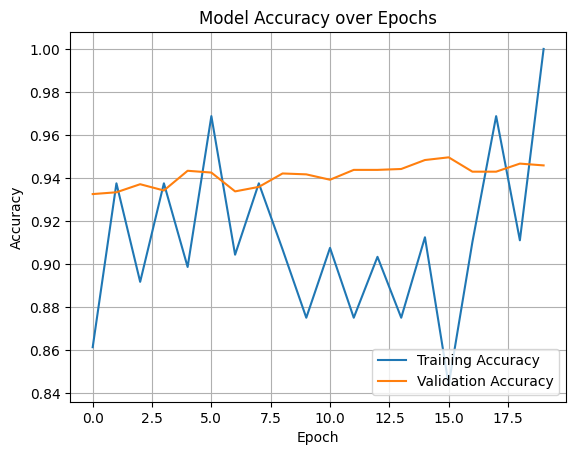

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [15]:
from tensorflow.keras.callbacks import Callback

class TestAccuracyCallback(Callback):
    def __init__(self, test_generator):
        super().__init__()
        self.test_generator = test_generator
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(
            self.test_generator,
            steps=self.test_generator.samples // self.test_generator.batch_size,
            verbose=0
        )
        self.test_accuracies.append(acc)
        print(f"\nTest accuracy after epoch {epoch+1}: {acc:.4f}")


In [16]:
# Initialize the callback
test_callback = TestAccuracyCallback(test_generator)

# Train the model with the callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[test_callback]
)


Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9185 - loss: 0.1914
Test accuracy after epoch 1: 0.9443
444/444 ━━━━━━━━━━━━━━━━━━━━ 191s 431ms/step - accuracy: 0.9185 - loss: 0.1914 - val_accuracy: 0.9446 - val_loss: 0.1394
Epoch 2/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9375 - loss: 0.2081
Test accuracy after epoch 2: 0.9468
444/444 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.9375 - loss: 0.2081 - val_accuracy: 0.9463 - val_loss: 0.1332
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9278 - loss: 0.1787
Test accuracy after epoch 3: 0.9392
444/444 ━━━━━━━━━━━━━━━━━━━━ 192s 433ms/step - accuracy: 0.9278 - loss: 0.1787 - val_accuracy: 0.9425 - val_loss: 0.1385
Epoch 4/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.9375 - loss: 0.1302
Test accuracy after epoch 4: 0.9409
444/444 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9375 - loss: 0.1302 - val_accuracy: 0.9433 - val_loss: 0.1374
Epoch 5/10
444/444 ━━━━━

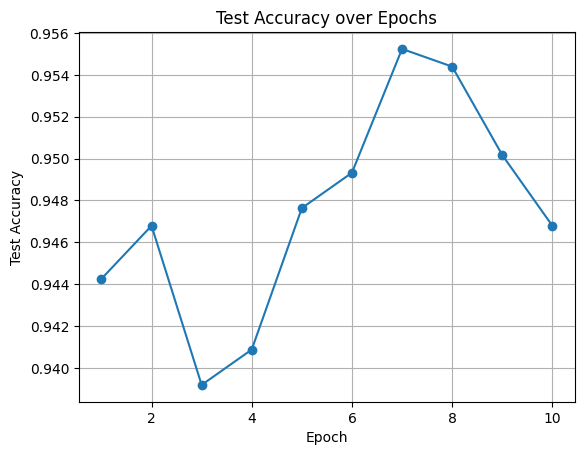

In [18]:
# Plot test accuracy per epoch
plt.plot(range(1, len(test_callback.test_accuracies) + 1), test_callback.test_accuracies, marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()


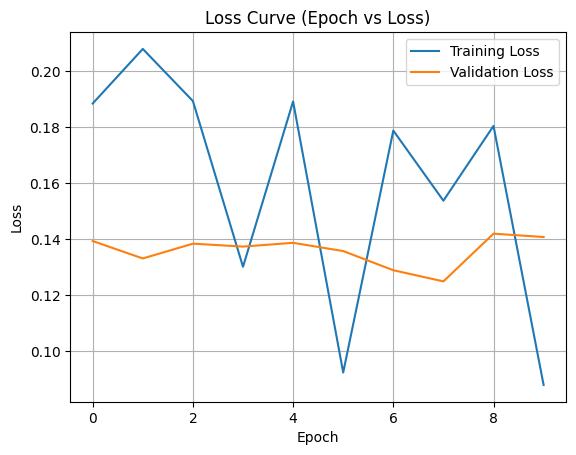

In [19]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss Curve (Epoch vs Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Reset the generator to start from the beginning
train_generator.reset()

# Initialize lists for true labels and predictions
train_labels = []
train_predictions = []

# Iterate through the batches
for i in range(train_generator.samples // train_generator.batch_size):
    images, labels = next(train_generator)  # Get batch
    predictions = model.predict(images, verbose=0)  # Predict batch
    train_labels.extend(labels)
    train_predictions.extend(np.round(predictions))  # Round to 0 or 1

# Convert to numpy arrays
train_labels = np.array(train_labels).astype(int)
train_predictions = np.array(train_predictions).astype(int)

# Generate and print confusion matrix
cm_train = confusion_matrix(train_labels, train_predictions)
print("Confusion Matrix for Training Data:")
print(cm_train)


Confusion Matrix for Training Data:
[[6303  592]
 [ 189 7124]]


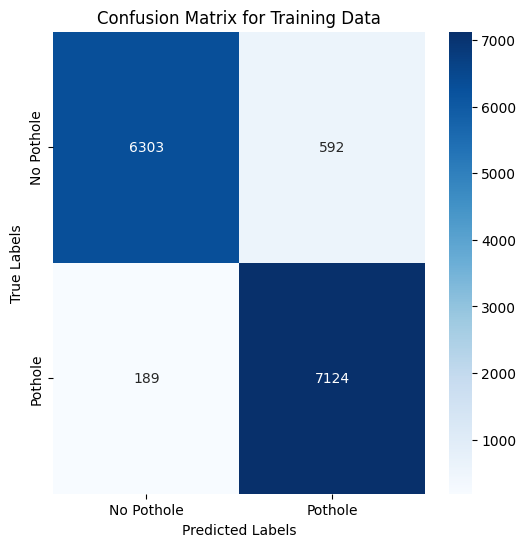

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for the training data
cm_train = confusion_matrix(train_labels, train_predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Pothole', 'Pothole'], yticklabels=['No Pothole', 'Pothole'])
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Accuracy: 0.9450
Precision: 0.9233
Recall: 0.9742
F1 Score: 0.9480


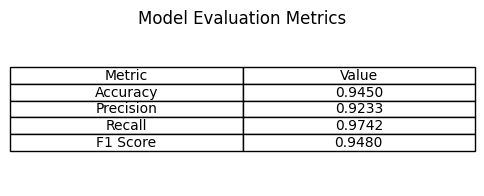

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming train_labels and train_predictions are already defined (from previous steps)

# Calculate Accuracy
accuracy = accuracy_score(train_labels, train_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision
precision = precision_score(train_labels, train_predictions)
print(f"Precision: {precision:.4f}")

# Calculate Recall
recall = recall_score(train_labels, train_predictions)
print(f"Recall: {recall:.4f}")

# Calculate F1 Score
f1 = f1_score(train_labels, train_predictions)
print(f"F1 Score: {f1:.4f}")

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate the metrics
accuracy = accuracy_score(train_labels, train_predictions)
precision = precision_score(train_labels, train_predictions)
recall = recall_score(train_labels, train_predictions)
f1 = f1_score(train_labels, train_predictions)

# Create the data for the table
metrics = [
    ['Accuracy', f'{accuracy:.4f}'],
    ['Precision', f'{precision:.4f}'],
    ['Recall', f'{recall:.4f}'],
    ['F1 Score', f'{f1:.4f}']
]

# Plotting the table
fig, ax = plt.subplots(figsize=(6, 2))  # Set size of the figure
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics, colLabels=['Metric', 'Value'], loc='center', cellLoc='center')

# Display the table
plt.title("Model Evaluation Metrics")
plt.show()

In [23]:
# Save the model
model.save('VGG15.h5')  # Save as a .h5 file

print("Model saved successfully!")


Model saved successfully!
